# Script 12: Precipitação Instantânea e Precipitação Acumulada
Neste script vamos criar plots de precipitação instantânea e precipitação acumulada.

Init: 2021-07-22 00:00:00 UTC
Run: 00Z
Forecast: +24
Valid: 2021-07-23 00:00:00 UTC


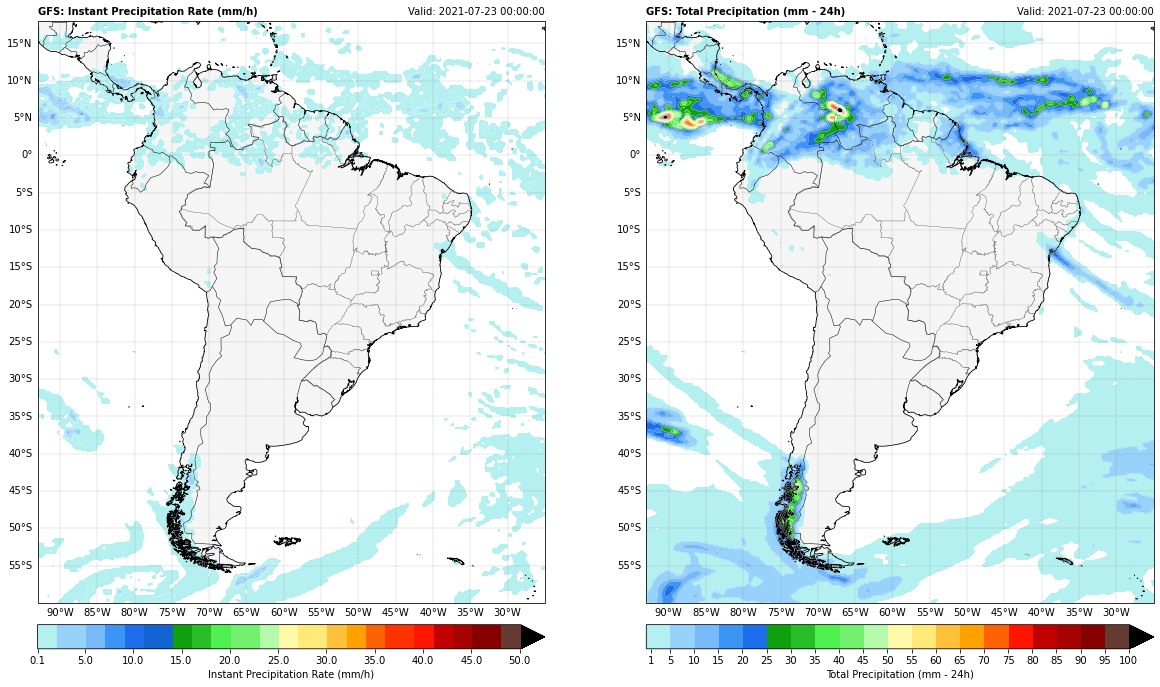

In [1]:
#-----------------------------------------------------------------------------------------------------------
# Curso INPE / CPTEC Training: NWP Data Processing With Python - Script 12: Precipitation 
# Instrutor: Diego Souza
# Adaptado: Dejanira F Braz
#-----------------------------------------------------------------------------------------------------------
import pygrib                              # Provides a high-level interface to the ECWMF ECCODES C library for reading GRIB files
import matplotlib.pyplot as plt            # Plotting library
import cartopy, cartopy.crs as ccrs        # Plot maps
import cartopy.io.shapereader as shpreader # Import shapefiles
import numpy as np                         # Scientific computing with Python
import matplotlib                          # Comprehensive library for creating static, animated, and interactive visualizations in Python 
#-----------------------------------------------------------------------------------------------------------  

# Select the extent [min. lon, min. lat, max. lon, max. lat]
extent = [-93.0, -60.00, -25.00, 18.00]

# Open the GRIB file
grib = pygrib.open("Samples/gfs.t00z.pgrb2.0p50.f024")

#-----------------------------------------------------------------------------------------------------------

# Read the instant precip 
grb = grib.select(name='Precipitation rate', typeOfLevel = 'surface')[0]

# Get information from the file    
init  = str(grb.analDate)      # Init date / time
run   = str(grb.hour).zfill(2) # Run
ftime = str(grb.forecastTime)  # Forecast hour
valid = str(grb.validDate)     # Valid date / time 
print('Init: ' + init + ' UTC')
print('Run: ' + run + 'Z')
print('Forecast: +' + ftime)
print('Valid: ' + valid + ' UTC')

#-----------------------------------------------------------------------------------------------------------

# Read the data for a specific region
precip, lats, lons = grb.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)

# Convert from kg m**-2 s**-1 to mm/h
precip = precip * 60 * 60

# Smooth the contours
import scipy.ndimage
precip = scipy.ndimage.zoom(precip, 3)
lats = scipy.ndimage.zoom(lats, 3)
lons = scipy.ndimage.zoom(lons, 3)

# Remove values lower than 0.1
precip[precip < 0.1] = np.nan

#-----------------------------------------------------------------------------------------------------------

# Select the variable
totpr = grib.select(name='Total Precipitation', typeOfLevel = 'surface')[1]

# Read the data for a specific region
totpr = totpr.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)[0]

# Smooth the contours
totpr = scipy.ndimage.zoom(totpr, 3)

# Remove values lower than 1.0
totpr[totpr < 1.0] = np.nan

#-----------------------------------------------------------------------------------------------------------

# Create a custom color palette 
colors = ["#b4f0f0", "#96d2fa", "#78b9fa", "#3c95f5", "#1e6deb", "#1463d2", 
          "#0fa00f", "#28be28", "#50f050", "#72f06e", "#b3faaa", "#fff9aa", 
          "#ffe978", "#ffc13c", "#ffa200", "#ff6200", "#ff3300", "#ff1500", 
          "#c00100", "#a50200", "#870000", "#653b32"]
cmap = matplotlib.colors.ListedColormap(colors)
cmap.set_over('#000000')
cmap.set_under('#ffffff')

#-----------------------------------------------------------------------------------------------------------

# Choose the plot size (width x height, in inches)
fig, axs = plt.subplots(1,2, figsize=(20,20), sharex = False, sharey = False, subplot_kw=dict(projection=ccrs.PlateCarree())) # 1 row x 2 columns

#-----------------------------------------------------------------------------------------------------------

# Define the image extent
axs[0].set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Add a background image
import cartopy.feature as cfeature
land = axs[0].add_feature(cfeature.LAND, facecolor='whitesmoke')
ocean = axs[0].add_feature(cfeature.OCEAN, facecolor='white')

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('Shapefile/BR_UF_2019.shp').geometries())
axs[0].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
axs[0].coastlines(resolution='10m', color='black', linewidth=0.8)
axs[0].add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Define de contour interval
data_min = 0.1
data_max = 50
interval = 1
levels = np.arange(data_min,data_max + interval,interval)

# Plot the contours
img1 = axs[0].contourf(lons, lats, precip, cmap=cmap, levels=levels, extend='max') 
img2 = axs[0].contour(lons, lats, precip, colors='white', linewidths=0.3, levels=levels)

# Define the ticks to be shown
ticks = [0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Add a colorbar
plt.colorbar(img1, label='Instant Precipitation Rate (mm/h)', orientation='horizontal', pad=0.02, fraction=0.05, ticks=ticks, ax=axs[0])

# Add a title
axs[0].set_title('GFS: Instant Precipitation Rate (mm/h)' , fontweight='bold', fontsize=10, loc='left')
axs[0].set_title('Valid: ' + valid, fontsize=10, loc='right')

#-----------------------------------------------------------------------------------------------------------

# Define the image extent
axs[1].set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Add a background image
import cartopy.feature as cfeature
land = axs[1].add_feature(cfeature.LAND, facecolor='whitesmoke')
ocean = axs[1].add_feature(cfeature.OCEAN, facecolor='white')

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('Shapefile/BR_UF_2019.shp').geometries())
axs[1].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
axs[1].coastlines(resolution='10m', color='black', linewidth=0.8)
axs[1].add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Define de contour interval
data_min = 0.1
data_max = 100 
interval = 5
levels = np.arange(data_min,data_max + interval,interval)

# Plot the contours (high values)
img3 = axs[1].contourf(lons, lats, totpr, cmap=cmap, levels=levels, extend='max')    
img4 = axs[1].contour(lons, lats, totpr, colors='white', linewidths=0.3, levels=levels)

# Define the ticks to be shown
ticks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Add a colorbar
plt.colorbar(img3, label='Total Precipitation (mm - 24h)', orientation='horizontal', pad=0.02, fraction=0.05,  ticks=ticks, ax=axs[1])

# Add a title
axs[1].set_title('GFS: Total Precipitation (mm - 24h)' , fontweight='bold', fontsize=10, loc='left')
axs[1].set_title('Valid: ' + valid, fontsize=10, loc='right')

#----------------------------------------------------------------------------------------------------------- 
# Save the image
plt.savefig('Figure/image_12.png')

# Show the image
plt.show()